In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\pot8o\AppData\Local\Temp\ipykernel_39708\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


One year ago: 2016-08-23 00:00:00
         date  precipitation
0  2016-08-24           0.08
1  2016-08-25           0.08
2  2016-08-26           0.00
3  2016-08-27           0.00
4  2016-08-28           0.01


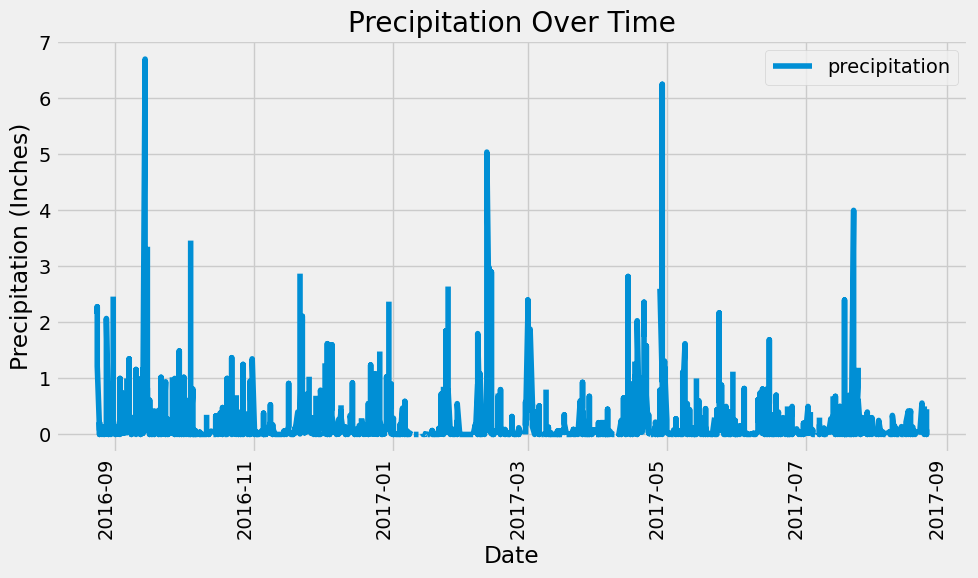

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
from datetime import datetime, timedelta

# Assume most_recent_date is already a datetime object
# Calculate the date one year from the last date in the dataset
one_year_ago = most_recent_date - timedelta(days=365)
print(f"One year ago: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])
print(precipitation_df.head())

# Sort the DataFrame by date
precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])
precipitation_df.sort_values(by="date", inplace=True)

# Plot the data
import matplotlib.pyplot as plt
precipitation_df.plot(
    x="date", y="precipitation", figsize=(10, 6), title="Precipitation Over Time"
)
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df["precipitation"].describe()
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
# List the stations and their counts in descending order.
for station, count in active_stations:
    print(f"Station: {station}, Observations: {count}")

Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [18]:
# Get the station ID with the highest number of observations
most_active_station = active_stations[0][0]
print(f"Most active station ID: {most_active_station}")

Most active station ID: USC00519281


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station)
    .all()
)

# Extract and print the results
min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Min Temperature: {min_temp}°F")
print(f"Max Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.1f}°F")

Temperature Statistics for Station USC00519281:
Min Temperature: 54.0°F
Max Temperature: 85.0°F
Average Temperature: 71.7°F


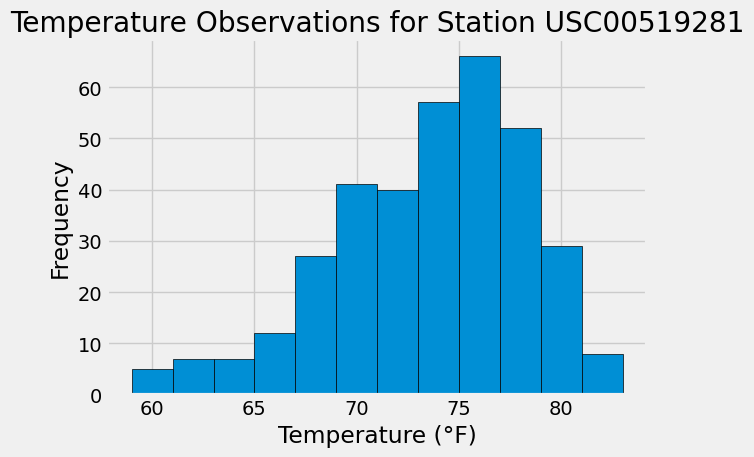

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Convert temperature data to a list
temperature_list = [temp[0] for temp in temperature_data]

# Plot the temperature observations as a histogram
import matplotlib.pyplot as plt

plt.hist(temperature_list, bins=12, edgecolor='black')
plt.title(f"Temperature Observations for Station {most_active_station}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [21]:
# Close Session
session.close()